### Настройка среды

In [1]:
import os
import sys

### Yandex Datasphere
# sys.path.append(os.path.abspath(".."))

### Google Colab
!git clone https://github.com/Belashov641618/OpticalEncoder.git
sys.path.append(os.path.abspath("OpticalEncoder"))

Cloning into 'OpticalEncoder'...
remote: Enumerating objects: 382, done.
remote: Counting objects: 100% (382/382), done.
remote: Compressing objects: 100% (242/242), done.
remote: Total 382 (delta 212), reused 282 (delta 119), pack-reused 0
Receiving objects: 100% (382/382), 18.93 MiB | 21.75 MiB/s, done.
Resolving deltas: 100% (212/212), done.


In [2]:
%pip install belashovplot

  Preparing metadata (setup.py) ... done
  Created wheel for belashovplot: filename=belashovplot-1.0-py3-none-any.whl size=12758 sha256=13b61af0c101a9bc3484198082a59ab88371e0963fcb714bdb7e834b2adfe5b4
  Stored in directory: /root/.cache/pip/wheels/55/7b/e2/e5bf08c4c48d0989afbcb220497fa4bb6805a32f6c7826eece
Successfully built belashovplot


In [3]:
from belashovplot import TiledPlot
from utilities import *
from utilities.filters import Gaussian, Window
from elements.modulators import Lens, PhaseModulator
from elements.propagators import FurrierPropagation, ConvolutionalPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent
from elements.detectors import ClassificationDetectors, MatrixDetectors
from parameters import FigureWidthHeight, FontLibrary
from tqdm import tqdm
from math import sin, sqrt
from pickle import dump
import torch
import numpy

### Цель эксперемента

Целью данного эксперемента является задание системы ...

### Настройка некогерентности

In [4]:
spatial_coherence = 50.0E-6
time_coherence = 10.0E-9
time_relaxation = 1.0E-6
mean_samples = 5 #100

print(f"Временная когерентность:        {engineering(time_coherence, 'с')}")
print(f"Время релаксации:               {engineering(time_relaxation, 'c')}")
print(f"Пространственная когерентность: {engineering(spatial_coherence, 'м')}")

Временная когерентность:        10.0 нс
Время релаксации:               1.0 мкc
Пространственная когерентность: 50.0 мкм


## Система без линз

Описание системы

### Настройка параметров системы

In [5]:
length = 10.0E-3
wavelength = 500E-9
mask_unit_length = 20.0E-6
masks_amount = 5
cppp = 1

pixels = int(length/mask_unit_length) + 1
N = int(pixels*cppp)
distance = length * sqrt((mask_unit_length/wavelength)**2-1) * 0.01

print(f"Длинна волны:                             {engineering(wavelength, 'м')}")
print(f"Количество вычислительных пикселей:       {N}")
print(f"Количество пикселей маски:                {pixels}")
print(f"Количество модуляторов:                   {masks_amount}")
print(f"Размер оптических элементов:              {engineering(length, 'м')}")
print(f"Размер пикселя маски:                     {engineering(mask_unit_length, 'м')}")
print(f"Расстояние между слоями:                  {engineering(distance, 'м')}")

Длинна волны:                             500.0 нм
Количество вычислительных пикселей:       500
Количество пикселей маски:                500
Количество модуляторов:                   5
Размер оптических элементов:              10.0 мм
Размер пикселя маски:                     20.0 мкм
Расстояние между слоями:                  3.999 мм


### Отрисовка некогерентности

0.0016469015972688794 0.48211465664062503
4.5969798520673066e-05 0.2975162139490659
6.969960668357089e-05 0.18359926698633297
4.6900921006454155e-05 0.11330034888011054
5.339752169675194e-05 0.13983682252184965
5.07106124132406e-05 0.17258849709014415
4.5978395064594224e-05 0.21301105667772507
0.00031712293275631964 0.26290112627414564
0.0025710330810397863 9.564287257458841e-13
Parameter containing:
tensor([0.1383, 0.4367, 1.0112, 1.0122], device='cuda:0')


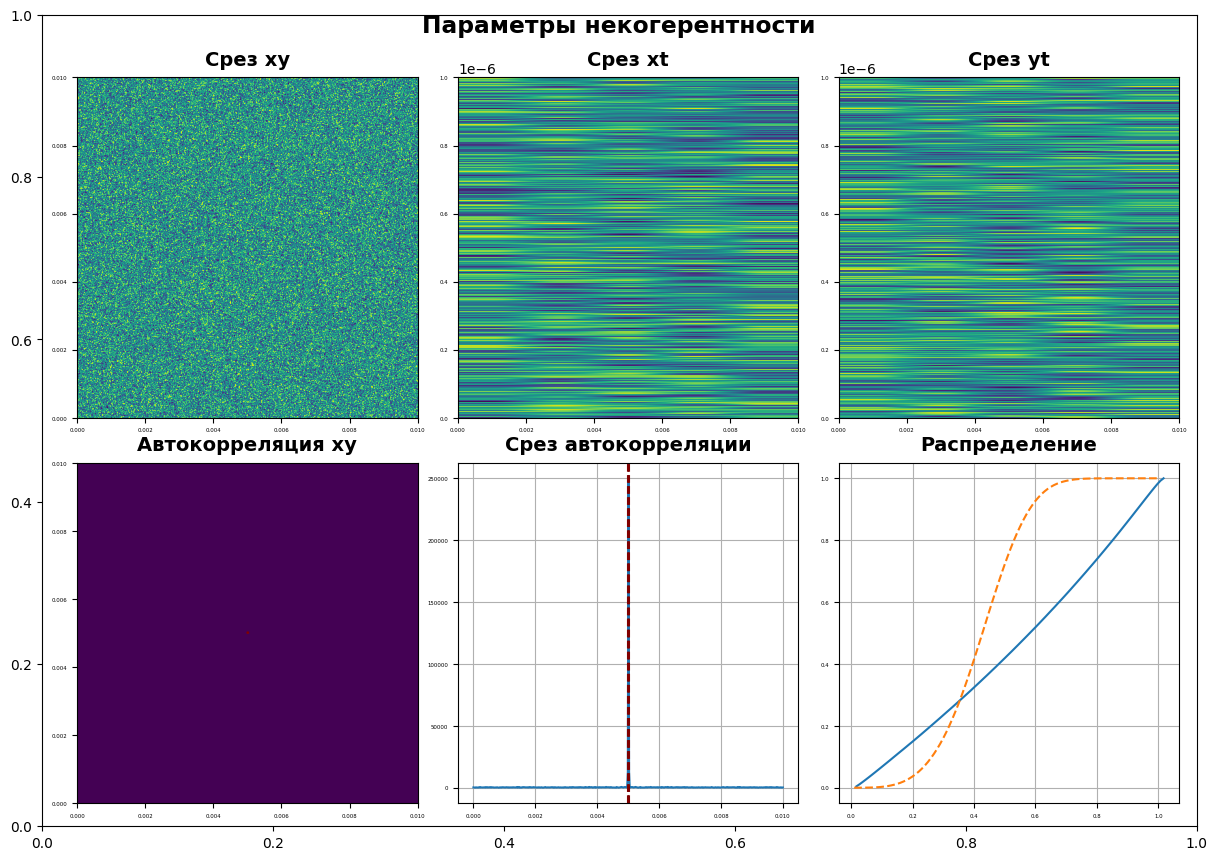

In [6]:
incoherent = Incoherent(spatial_coherence, time_coherence, time_relaxation, mean_samples, N, length)
incoherent = incoherent.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
incoherent.delayed.launch()
incoherent.show()

### Инициализация оптической модели

In [7]:
propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance, 0.25)
modulators = [PhaseModulator(N, length, pixels) for i in range(masks_amount)]
elements = [modulators[0]]
for modulator in modulators[1:]:
    elements.append(propagation)
    elements.append(modulator)
elements.append(propagation)

chunker = CudaMemoryChunker()

optical = CompositeModel(*elements)
optical.wrap(chunker)
optical.wrap(incoherent)
optical.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

CompositeModel(
  (Element0): PhaseModulator()
  (Element1): FurrierPropagation()
  (Element2): PhaseModulator()
  (Element3): FurrierPropagation()
  (Element4): PhaseModulator()
  (Element5): FurrierPropagation()
  (Element6): PhaseModulator()
  (Element7): FurrierPropagation()
  (Element8): PhaseModulator()
  (Element9): FurrierPropagation()
  (Wrapper0): CudaMemoryChunker()
  (Wrapper1): Incoherent(
    (_generator): GaussianNormalizer(
      (_generator): FourierMask()
    )
  )
)

### Инициализация детекторов

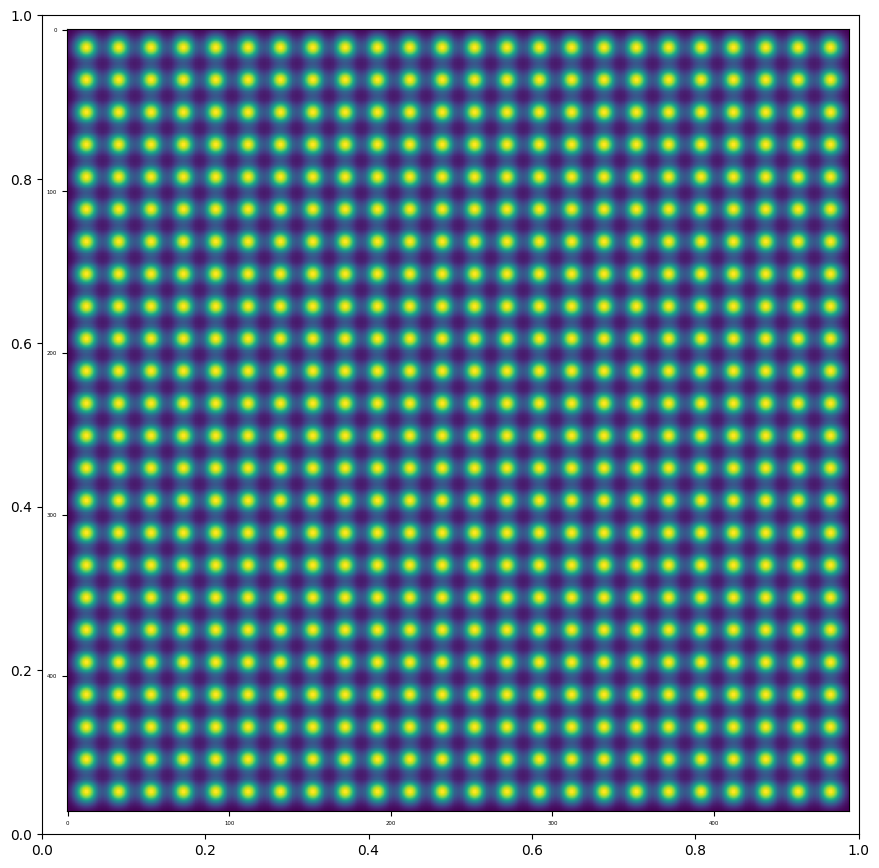

In [9]:
detectors_amount = 24

spectral_filter = Window(centers=wavelength, sizes=300.0E-9)
detectors_filter = Gaussian((length/100, length/100), (0,0))
detectors = MatrixDetectors(N, length, wavelength, detectors_amount, detectors_filter, spectral_filter)
detectors.to(optical.device)

plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.axes.add(0,0).imshow(detectors.filter, aspect='auto')
plot.show()

### Инициализация электронной модели

In [10]:
electronic = torch.nn.Sequential(
            torch.nn.Linear(detectors_amount**2, detectors_amount**2),  # Поддержание той же размерности
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),    # Dropout для регуляризации
            torch.nn.Linear(detectors_amount**2, detectors_amount**2),  # Поддержание той же размерности
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(detectors_amount**2, 10)   # Выходной слой для 10 классов
        )
electronic.to(optical.device)

Sequential(
  (0): Linear(in_features=576, out_features=576, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=576, out_features=576, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=576, out_features=10, bias=True)
)

### Инициализация гибридной модели

In [11]:
model = HybridModel(optical, detectors, electronic)

In [12]:
dataset = Dataset('CIFAR10', 50, N, N, torch.complex64)
dataset.train
dataset.test

100%|██████████| 170498071/170498071 [00:03<00:00, 43044193.88it/s]


Extracting /content/OpticalEncoder/datasets/cifar-10-python.tar.gz to /content/OpticalEncoder/datasets
Files already downloaded and verified


100%|██████████| 10/10 [00:00<00:00, 57.58it/s]


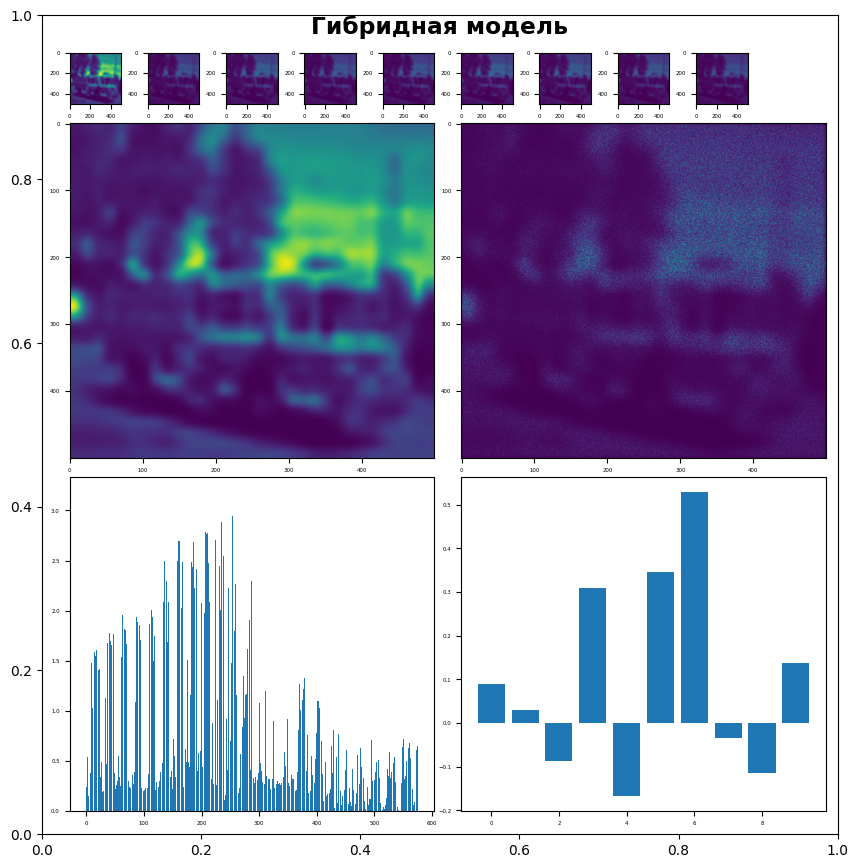

100%|██████████| 10/10 [00:00<00:00, 290.49it/s]


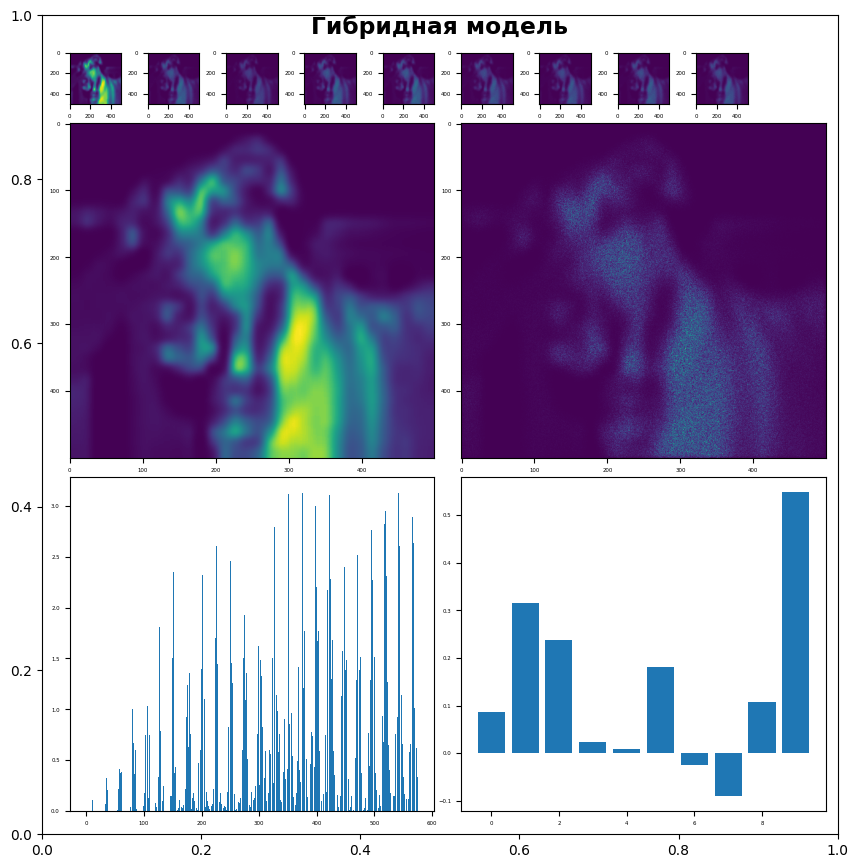

In [13]:
dsi = iter(dataset.train)
with torch.no_grad():
    model.visualize(next(dsi)[0][:1, :1].to(model.device))
    model.visualize(next(dsi)[0][:1, :1].to(model.device))

### Инициализация лосс функции и обучающего модуля

In [14]:
CrossEntropy = torch.nn.CrossEntropyLoss()
def loss_function(results:torch.Tensor, labels0:torch.Tensor):
    return CrossEntropy(results, labels0)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

def epoch(record_memory:int=0):
    memory_trigger = False
    model.train()
    torch.cuda.empty_cache()
    history = []
    iterator = tqdm(dataset.train)
    for images, labels in iterator:

        if record_memory and not memory_trigger:
            memory_trigger = True
            torch.cuda.memory._record_memory_history(True, trace_alloc_max_entries=100000, trace_alloc_record_context=True)

        optimizer.zero_grad()

        labels = labels.to(model.device)
        images = images.to(model.device)
        results = model.forward(images)

        loss = loss_function(results, labels)
        loss.backward()
        optimizer.step()

        if memory_trigger:
            record_memory -= 1
        if memory_trigger and not record_memory:
            memory_trigger = False
            s = torch.cuda.memory._snapshot()
            with open(f"snapshot.pickle", "wb") as f:
                dump(s, f)
            torch.cuda.memory._record_memory_history(enabled=None)

        history.append(loss.item())
        iterator.set_description(f"Loss: {loss.item()}")
        iterator.refresh()
    return history

def accuracy():
    model.eval()
    torch.cuda.empty_cache()
    confusion = torch.zeros((10, 10), device=model.device)
    with torch.no_grad():
        iterator = tqdm(dataset.test)
        for images, labels in iterator:
            images = images.to(model.device)
            results = model.forward(images)
            values, indexes = torch.max(results, dim=1)
            for label, index in zip(labels, indexes):
                confusion[label.item(), index.item()] += 1
    return confusion.cpu()

### Обучение модели

In [15]:
history = []
confusions = []

In [ ]:
confusions.append(accuracy())
print(100 * torch.sum(torch.diagonal(confusions[-1], 0)) / torch.sum(confusions[-1]))
for i in range(10):
  history += epoch()
  confusions.append(accuracy())
  print(100 * torch.sum(torch.diagonal(confusions[-1], 0)) / torch.sum(confusions[-1]))

100%|██████████| 200/200 [01:55<00:00,  1.74it/s]


tensor(12.8600)


100%|██████████| 200/200 [01:54<00:00,  1.74it/s]


tensor(31.3600)


100%|██████████| 200/200 [01:54<00:00,  1.75it/s]


tensor(35.3600)


100%|██████████| 200/200 [01:54<00:00,  1.75it/s]


tensor(36.6800)


100%|██████████| 200/200 [01:54<00:00,  1.75it/s]


tensor(38.1500)


100%|██████████| 200/200 [01:54<00:00,  1.74it/s]


tensor(39.5400)


100%|██████████| 200/200 [01:54<00:00,  1.74it/s]


tensor(40.0600)


100%|██████████| 200/200 [01:54<00:00,  1.75it/s]


tensor(40.5000)


100%|██████████| 200/200 [01:54<00:00,  1.74it/s]


tensor(41.3400)


100%|██████████| 200/200 [01:54<00:00,  1.74it/s]


tensor(41.4600)


Loss: 1.8601679801940918:  75%|███████▍  | 748/1000 [13:45<04:39,  1.11s/it]

In [ ]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.axes.add(0,0).plot(history)
# plot.axes.add(0,0).imshow(image.cpu().abs()[0][0]**2)
plot.show()

In [ ]:
dsi = iter(dataset.train)
with torch.no_grad():
    model.visualize(next(dsi)[0][:1, :1].to(model.device))
    model.visualize(next(dsi)[0][:1, :1].to(model.device))

In [ ]:
print(confusions[0], '\n', confusions[-1])